# Handwritten Digit Recognition in PyTorch

Using a Convolutional Neural Network

#### Imports

In [18]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

# Data
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader


#### Load Data

In [11]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
    
)

In [12]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [13]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

Dataloaders (load data in batches)

In [14]:
loaders = {

    'train' : DataLoader(train_data,
                         batch_size=100,
                         shuffle=True,
                         num_workers=1),

    'test' : DataLoader(train_data,
                         batch_size=100,
                         shuffle=True,
                         num_workers=1)

}

#### Model Architecture

In [15]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10) # Output 10 bc going to use softmax, 10 digits -> 10 probabilities


    # Forward Prop
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten Data for linear layer
        x = x.view(-1, 320)  #(20 channels * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)

        return F.softmax(x)        

#### Training and Testing

In [16]:
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device) # Move to gpu if cuda capable

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

# Model Training Mode
def train(epoch):
    model.train()

    for batch_idx, (data,target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        # Zero out gradients for each batch before back prop
        optimizer.zero_grad()
        # Model prediction in current state of training
        output = model(data)
        # Given that prediciton, calculate loss
        loss = loss_fn(output, target)
        # Back prop (optimimize with stored gradients)
        loss.backward()
        optimizer.step()

        # logging
        if batch_idx % 20 == 0:
            # Prints:  Current Epoch    |             Batches Handled / Total Batches            |           % Batches Handled                    |        Loss
            print(f"Train epoch: {epoch} [{batch_idx*len(data)} / {len(loaders['train'].dataset)} ({100. * batch_idx / len(loaders['train']):.0f}%)] \t{loss.item():.6f}") 

# Model Testing Mode
def test():
    model.eval()

    test_loss = 0
    correct = 0

    # Disable gradient calc b/c inferrence
    with torch.no_grad():
        # For samples in the batch, compare if target & predicted are the same. Sum up correct predictions
        for data,target in loaders['test']:
            data,target = data.to(device), target.to(device)
            output = model(data)

            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True) # whichever has max activation val
            correct += pred.eq(target.view_as(pred)).sum().item() # Shape target same way as prediction

    test_loss / len(loaders['test'].dataset)

    print(f"\nTest Set: Average Loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.0f}%\n)")




In [17]:
for epoch in range(1,11):
    train(epoch)
    test()

/tmp/ipykernel_181837/3933862324.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train epoch: 1 [0 / 60000 (0%)] 	2.300872
Train epoch: 1 [2000 / 60000 (3%)] 	2.280720
Train epoch: 1 [4000 / 60000 (7%)] 	2.204507
Train epoch: 1 [6000 / 60000 (10%)] 	2.019502
Train epoch: 1 [8000 / 60000 (13%)] 	1.943617
Train epoch: 1 [10000 / 60000 (17%)] 	1.817288
Train epoch: 1 [12000 / 60000 (20%)] 	1.875121
Train epoch: 1 [14000 / 60000 (23%)] 	1.775912
Train epoch: 1 [16000 / 60000 (27%)] 	1.788620
Train epoch: 1 [18000 / 60000 (30%)] 	1.757447
Train epoch: 1 [20000 / 60000 (33%)] 	1.742171
Train epoch: 1 [22000 / 60000 (37%)] 	1.744795
Train epoch: 1 [24000 / 60000 (40%)] 	1.730681
Train epoch: 1 [26000 / 60000 (43%)] 	1.656630
Train epoch: 1 [28000 / 60000 (47%)] 	1.712821
Train epoch: 1 [30000 / 60000 (50%)] 	1.682822
Train epoch: 1 [32000 / 60000 (53%)] 	1.729223
Train epoch: 1 [34000 / 60000 (57%)] 	1.661800
Train epoch: 1 [36000 / 60000 (60%)] 	1.697389
Train epoch: 1 [38000 / 60000 (63%)] 	1.645145
Train epoch: 1 [40000 / 60000 (67%)] 	1.688740
Train epoch: 1 [42000 / 

#### Visualizing

Prediction: 7


/tmp/ipykernel_181837/3933862324.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


<function matplotlib.pyplot.show(close=None, block=None)>

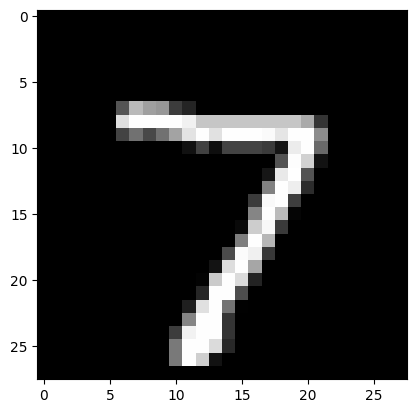

In [19]:
model.eval()

data, target = test_data[0]

# Adding a batch dimension to enter as a collection/list with 1 data point
data = data.unsqueeze(0).to(device)

output = model(data) 

prediction = output.argmax(dim=1, keepdim = True).item()

print(f"Prediction: {prediction}")

# Unpack image from the data, squeeze out channel dimensions, send back to cpu, turn back into a numpy array to display
image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show